
The *Anopheles gambiae* voltage-gated sodium channel gene (a.k.a. *vgsc*, *para*, *AgNa<sub>V</sub>*) is the target for DDT and pyrethroid insecticides. Mutations in this gene cause insecticide resistance, so it's an important gene for malaria vector control.

In 2007, [Emyr Davies et al.](https://www.ncbi.nlm.nih.gov/pubmed/17433068) published a complete cDNA sequence for the *An. gambiae* *vgsc* gene. They inferred 35 exons and found evidence for alternate splicing involving at least five optional exons and two sets of mutually exclusive exons. 

The official source for *An. gambiae* gene annotations is [VectorBase](@@TODO). The AgamP4.4 gene annotations include three transcripts for *vgsc*. However, these transcripts were derived from a different source and do not represent the larger set of exons and splice variants reported by Davies et al. 

In our analyses for the [Ag1000G project](@@TODO) we've been using the VectorBase gene model, and I was concerned we could be missing important functional variation. So I went back to the Davies et al. paper and constructed a [GFF file](@@TODO) with a set of 10 putative transcripts based on the cDNAs they observed.

The first part of this article compares the exons and splice variants observed by Davies et al. with the transcripts in the VectorBase gene annotations. At the end of the article I'll explain the steps I went through to build a GFF from the information given in the Davies et al. paper.

This article was generated from a [Jupyter notebook](@@TODO). It includes some Python code used to load data and generate plots. If you're only interested in the biology you can safely skip over the code.

## Setup

Use [scikit-allel](@@TODO) and [pandas](@@TODO) to load the AgamP4.4 gene annotations which I've [downloaded from VectorBase](@@TODO).

In [1]:
import allel
import pandas


def geneset_to_pandas(geneset):
    """Life is a bit easier when a geneset is a pandas DataFrame."""
    items = []
    for n in geneset.dtype.names:
        v = geneset[n]
        # convert bytes columns to unicode (which pandas then converts to object)
        if v.dtype.kind == 'S':
            v = v.astype('U')
        items.append((n, v))
    return pandas.DataFrame.from_items(items)


geneset_agamp44 = allel.FeatureTable.from_gff3('data/Anopheles-gambiae-PEST_BASEFEATURES_AgamP4.4.gff3.gz',
                                               attributes=['ID', 'Parent'])
geneset_agamp44 = geneset_to_pandas(geneset_agamp44)

Extract annotations for the *vgsc* gene.

In [2]:
region_vgsc = '2L', 2358158, 2431617
geneset_agamp44_vgsc = geneset_agamp44.query("(seqid == %r) & (start >= %s) & (end <= %s)" % region_vgsc).copy()
# replace CDS IDs as not informative
geneset_agamp44_vgsc['ID'].values[(geneset_agamp44_vgsc.type == 'CDS').values] = ''

Load gene annotations derived from Davies et al.

In [3]:
geneset_davies = allel.FeatureTable.from_gff3('data/davies_vgsc_model_20170125.gff3',
                                              attributes=['ID', 'Parent'])
geneset_davies = geneset_to_pandas(geneset_davies)

Make a combined geneset.

In [4]:
geneset_vgsc_combined = pandas.concat([geneset_agamp44_vgsc, geneset_davies])

Define a function for plotting transcripts.

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
sns.set_style('ticks')
import humanize
%matplotlib inline


def plot_transcripts(geneset, chrom, start, stop, height=.5, label_transcripts=True, label_exons=False, label_exon_size=False,
                     label_codons=False, highlight_exons=None, label_cdss=False, highlight_color='red', ax=None,
                     title=None):
    """Plot all transcripts for all genes overlapping a given region."""

    if ax is None:
        fig, ax = plt.subplots(figsize=(14, 6))
        sns.despine(ax=ax, left=True, offset=5)
        
    if title:
        ax.set_title(title, va='bottom')

    # find genes overlapping the given region 
    genes = geneset.query("(type == 'gene') and (seqid == %r) and (end >= %s) and (start <= %s)" % (chrom, start, stop)).sort_values('start')

    # iterate over genes
    for _, gene in genes.iterrows():

        # find child transcripts
        transcripts = geneset.query("(type == 'mRNA') and (Parent == %r)" % gene.ID).sort_values('ID')

        # iterate over transcripts
        for i, (_, transcript) in enumerate(transcripts.iterrows()):
            
            # coordinates for plotting the transcript
            if transcript.strand == '+':
                y = i
            else:
                y = -i - 1

            # annotate with transcript ID
            text_y = y + height + (height / 10)
            if label_transcripts == 'right':
                text_x = min(stop, transcript.end)
                ha = 'right'
            else:
                text_x = max(start, transcript.start)
                ha = 'left'
            if label_transcripts:
                if transcript.strand == '+':
                    text = '%s >' % transcript.ID
                else:
                    text = '< %s' % transcript.ID
                ax.text(text_x, text_y, text, ha=ha, va='bottom')
            
            # find child exons
            exons = geneset.query("type == 'exon' and Parent == %r" % transcript.ID).sort_values('start')
            
            # iterate over exons to plot introns
            last_exon = None
            for i, (_, exon) in enumerate(exons.iterrows()):
                x = exon.start
                width = exon.end - x

                # plot intron
                if last_exon is not None:
                    ax.plot([last_exon.end, (last_exon.end + exon.start) / 2, exon.start], [y + height / 2, y + height / 1.5, y + height / 2], 'k-')
                last_exon = exon
                
                # exon number
                n = i + 1 if exon.strand == '+' else len(exons) - i
                
                # label exons
                if label_exons and exon.end > start and exon.start < stop:
                    text_x = (exon.start + exon.end) / 2
                    ha = 'center'
                    if text_x < start:
                        text_x = start
                        ha = 'left'
                    elif text_x > stop:
                        text_x = stop
                        ha = 'right'
                    s = str(n)
                    if label_exon_size:
                        s += ' (%s)' % (exon.end - exon.start + 1)
                    if label_exons == 'center':
                        ax.text(text_x, y + height / 2, s, ha=ha, va='center', color='w', zorder=20, fontweight='bold')
                    else:
                        ax.text(text_x, text_y, s, ha=ha, va='bottom', color='k', zorder=20)
                
                # highlight exons
                if highlight_exons and (transcript.ID, n) in highlight_exons:
                    patch = plt.Rectangle((x, y), width, height, color=highlight_color, alpha=1, zorder=10)
                    ax.add_patch(patch)

            # find child CDSs
            cdss = geneset.query("type == 'CDS' and Parent == %r" % transcript.ID)
            if transcript.strand == '+':
                cdss = cdss.sort_values('start', ascending=True)
            else:
                cdss = cdss.sort_values('end', ascending=False)
                
            # keep track of CDS position
            cds_pos = 0
            
            # plot CDSs
            for _, cds in cdss.iterrows():
                x = cds.start
                width = cds.end - x
                
                # plot CDS
                patch = plt.Rectangle((x, y), width, height, color='k')
                ax.add_patch(patch)
                
                if label_codons:
                    # report 1-based numbers
                    s = '%s (%s)' % ((cds_pos // 3) + 1, cds_pos + 1)
                    if transcript.strand == '+':
                        text_x = x
                        ha = 'left'
                    else:
                        text_x = x + width
                        ha = 'right'
                    if text_x > start and text_x < stop:
                        ax.text(text_x, text_y, s, ha=ha, va='bottom')
                        
                # label CDSs
                if label_cdss and cds.end > start and cds.start < stop:
                    text_x = (cds.start + cds.end) / 2
                    ha = 'center'
                    if text_x < start:
                        text_x = start
                        ha = 'left'
                    elif text_x > stop:
                        text_x = stop
                        ha = 'right'
                    s = cds.ID
                    if label_cdss == 'center':
                        ax.text(text_x, y + height / 2, s, ha=ha, va='center', color='w', zorder=20, fontweight='bold')
                    else:
                        ax.text(text_x, text_y, s, ha=ha, va='bottom', color='k', zorder=20)
                
                # accumulate CDS positions
                cds_pos += width + 1  # N.B., GFF coords are 1-based end-inclusive

            # find child UTRs
            utrs = geneset.query("(type == 'three_prime_UTR' or type == 'five_prime_UTR') and Parent == %r" % transcript.ID).sort_values('start')
            for _, utr in utrs.iterrows():
                x = utr.start
                width = utr.end - x
                utr_height = height * .8
                utr_y = y + (height - utr_height) / 2
                patch = plt.Rectangle((x, utr_y), width, utr_height, facecolor='#cccccc', edgecolor='k')
                ax.add_patch(patch)

    ax.set_yticks([])
    ax.set_xlim(start, stop)
    ax.set_xticklabels([humanize.intcomma(int(x)) for x in ax.get_xticks()])
#     ax.axhline(0 - (height / 2), color='k', linestyle='--')
    ax.set_xlabel('Chromosome %s position (bp)' % chrom)
    ax.autoscale(axis='y', tight=True)


Identify the exons that are optional or variable in size between different transcripts, to highlight in plots below.

In [6]:
highlight_exons = [
    # optional exon j
    ('Davies-C8N9', 2),
    ('Davies-C8N2', 2),
    # length difference in exon 3
    ('Davies-C8N9', 3),
    ('Davies-C8N2', 3),
    ('Davies-C7N2', 2),
    ('Davies-C5N2', 2),
    ('Davies-C3N2', 2),
    ('Davies-C1N9ck', 2),
    ('Davies-C1N9', 2),
    ('Davies-C1N2', 2),
    ('Davies-C11N2', 2),
    ('Davies-C10N2', 2),
    ('AGAP004707-RC', 2),
    ('AGAP004707-RB', 2),
    ('AGAP004707-RA', 2),
    # exon 5 is missing in C3N2
    ('Davies-C8N9', 5),
    ('Davies-C8N2', 5),
    ('Davies-C7N2', 4),
    ('Davies-C5N2', 4),
    ('Davies-C1N9ck', 4),
    ('Davies-C1N9', 4),
    ('Davies-C1N2', 4),
    ('Davies-C11N2', 4),
    ('Davies-C10N2', 4),
    ('AGAP004707-RC', 4),
    ('AGAP004707-RB', 4),
    ('AGAP004707-RA', 4),
    # exon 10 is missing in C5N2
    ('Davies-C8N9', 10),
    ('Davies-C8N2', 10),
    ('Davies-C7N2', 9),
    ('Davies-C3N2', 8),
    ('Davies-C1N9ck', 9),
    ('Davies-C1N9', 9),
    ('Davies-C1N2', 9),
    ('Davies-C11N2', 9),
    ('Davies-C10N2', 9),
    ('AGAP004707-RC', 9),
    ('AGAP004707-RB', 9),
    ('AGAP004707-RA', 9),
    # optional exon 12
    ('Davies-C1N9ck', 11),
    ('Davies-C1N9', 11),
    ('Davies-C1N2', 11),
    # optional exon 13 (a)
    ('Davies-C1N9ck', 12),
    ('Davies-C1N9', 12),
    ('Davies-C1N2', 12),
    ('AGAP004707-RC', 11),
    ('AGAP004707-RB', 11),
    ('AGAP004707-RA', 11),
    # alternative exon 20 pair (c/d)
    ('Davies-C8N9', 18),
    ('Davies-C8N2', 18),
    ('Davies-C7N2', 17),
    ('Davies-C5N2', 16),
    ('Davies-C3N2', 16),
    ('Davies-C1N9ck', 19),
    ('Davies-C1N9', 19),
    ('Davies-C1N2', 19),
    ('Davies-C11N2', 17),
    ('Davies-C10N2', 17),
    ('AGAP004707-RC', 18),
    ('AGAP004707-RB', 18),
    ('AGAP004707-RA', 18),
    # length difference in exon 23 (f+/-)
    ('Davies-C8N9', 21),
    ('Davies-C8N2', 21),
    ('Davies-C7N2', 20),
    ('Davies-C5N2', 19),
    ('Davies-C3N2', 19),
    ('Davies-C1N9ck', 22),
    ('Davies-C1N9', 22),
    ('Davies-C1N2', 22),
    ('Davies-C11N2', 20),
    ('Davies-C10N2', 20),
    ('AGAP004707-RC', 21),
    ('AGAP004707-RB', 21),
    ('AGAP004707-RA', 21),
    # length difference in exon 24 (h+/-)
    ('Davies-C8N9', 22),
    ('Davies-C8N2', 22),
    ('Davies-C7N2', 21),
    ('Davies-C5N2', 20),
    ('Davies-C3N2', 20),
    ('Davies-C1N9ck', 23),
    ('Davies-C1N9', 23),
    ('Davies-C1N2', 23),
    ('Davies-C11N2', 21),
    ('Davies-C10N2', 21),
    ('AGAP004707-RC', 22),
    ('AGAP004707-RB', 22),
    ('AGAP004707-RA', 22),
    # alternative exon 27 pair (k/l)
    ('Davies-C8N9', 25),
    ('Davies-C8N2', 25),
    ('Davies-C7N2', 24),
    ('Davies-C5N2', 23),
    ('Davies-C3N2', 23),
    ('Davies-C1N9ck', 26),
    ('Davies-C1N9', 26),
    ('Davies-C1N2', 26),
    ('Davies-C11N2', 24),
    ('Davies-C10N2', 24),
    ('AGAP004707-RC', 25),
    ('AGAP004707-RB', 25),
    ('AGAP004707-RA', 25),
]

## Compare VectorBase and Davies gene models

Here's a plot of the entire gene, showing all transcripts together. Exons that are either optional or variable in size between transcripts are highlighted in red.

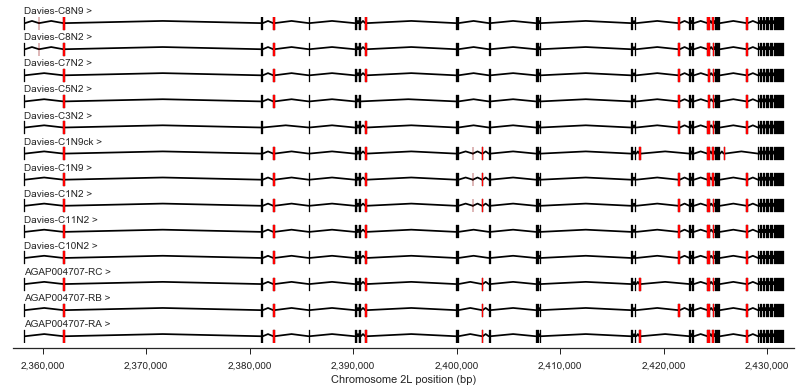

In [7]:
chrom, start, stop = region_vgsc
plot_transcripts(geneset_vgsc_combined, chrom, start-1000, stop+1000, highlight_exons=highlight_exons)

Let's work through the gene in detail, taking a few exons at a time. In the plots below, the text **above** the exons (e.g., "3 (156)") show the index of the exon within the transcript (e.g., 3rd exon) and the exon length (e.g., 156 bp long). The text **within** the exons shows the exon number **according to Davies et al.** supplementary table S1, along with a lower-case letter if the exon corresponds to a variable sequence previously identified in *Drosophila* (for a review of *vgsc* studies across insect species see [Dong et al. (2014)](@@TODO)).

In the text below I will refer to exons using the exon numbering according to Davies et al. table S1.

### Exons 1-3

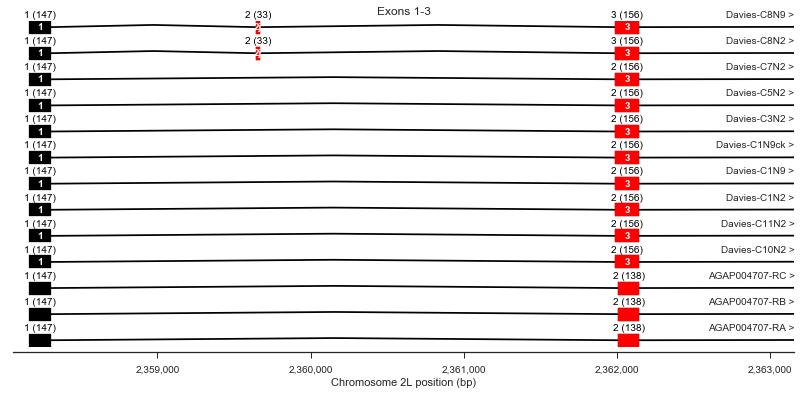

In [8]:
plot_transcripts(geneset_vgsc_combined, chrom, start-100, start+5000,
                 label_transcripts='right', label_exons=True, label_exon_size=True, 
                 label_cdss='center', highlight_exons=highlight_exons, title='Exons 1-3')

Exon 2 (also known as optional exon *j*) is observed in Davies cDNA C8 but not in any AgamP4.4 transcripts. 

Exon 3 is also longer in all Davies cDNAs (156 bp) than the AgamP4.4 transcripts (138 bp).

### Exons 4-6

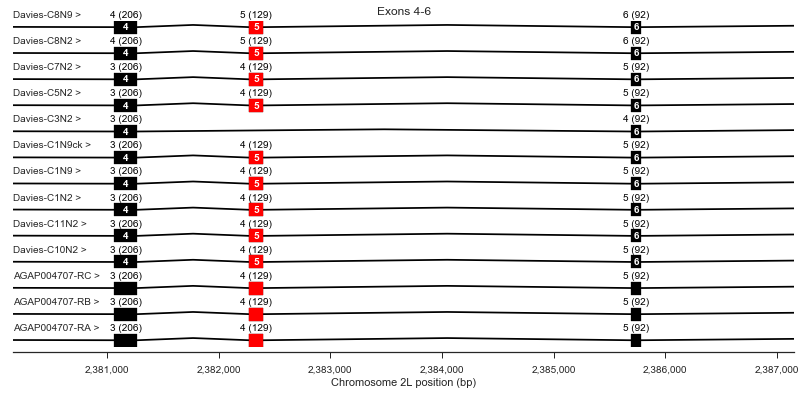

In [9]:
plot_transcripts(geneset_vgsc_combined, chrom, start+22000, start+29000,
                 label_transcripts='left', label_exons=True, label_exon_size=True, 
                 label_cdss='center', highlight_exons=highlight_exons, title='Exons 4-6')

Exon 5 is not present in Davies cDNA C3. Davies et al. mention that this exon is also optional in the German cockroach (*Blattella germanica*) but should render the channel non-functional because it would eliminate a key region of the voltage sensor.

### Exons 7-10

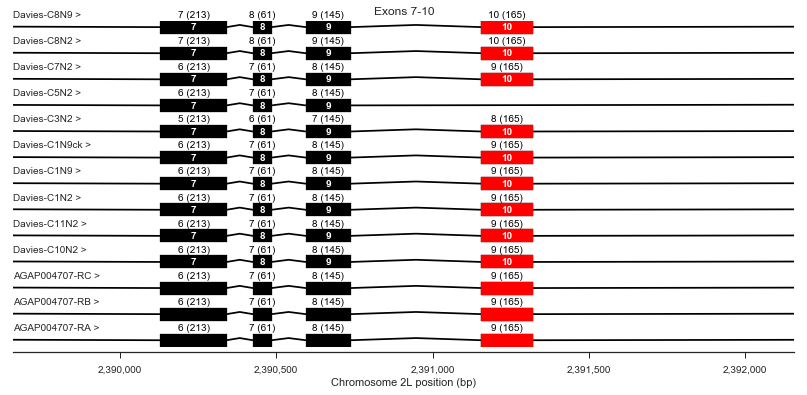

In [10]:
plot_transcripts(geneset_vgsc_combined, chrom, start+31500, start+34000,
                 label_transcripts='left', label_exons=True, label_exon_size=True, 
                 label_cdss='center', highlight_exons=highlight_exons, title='Exons 7-10')

Exon 10 is missing in Davies cDNA C5. Davies et al. state this should also render the channel non-functional because it would eliminate a key region of the channel pore.

### Exons 11-14

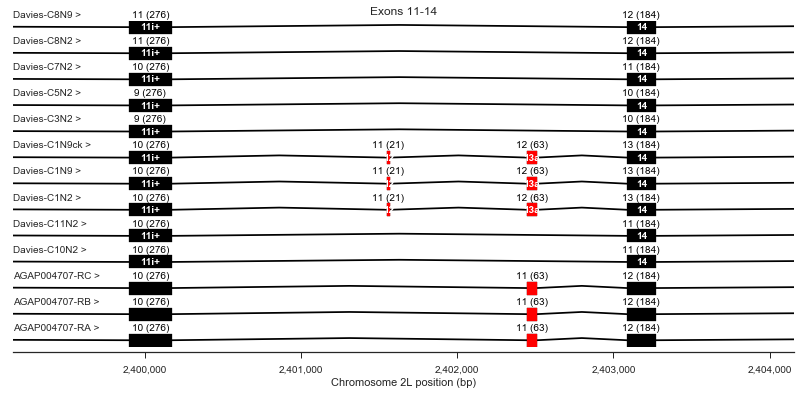

In [11]:
plot_transcripts(geneset_vgsc_combined, chrom, start+41000, start+46000,
                 label_transcripts='left', label_exons=True, label_exon_size=True, 
                 label_cdss='center', highlight_exons=highlight_exons, title='Exons 11-14')

Exon 12 is present in Davies cDNA C1 but is not in any other transcripts. 

Exon 13 (also known as optional exon *a*) is present in Davies cDNA C1 and in all AgamP4.4 transcripts but missing from other Davies cDNAs.

### Exons 15-17

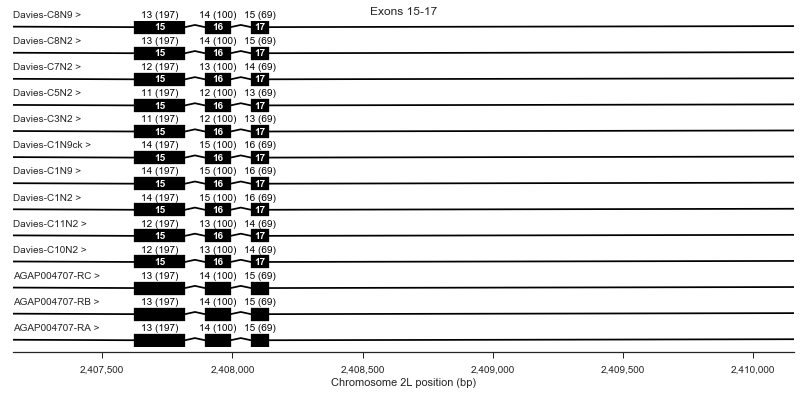

In [12]:
plot_transcripts(geneset_vgsc_combined, chrom, start+49000, start+52000,
                 label_transcripts='left', label_exons=True, label_exon_size=True, 
                 label_cdss='center', highlight_exons=highlight_exons, title='Exons 15-17')

No splice variation.

### Exons 18-20

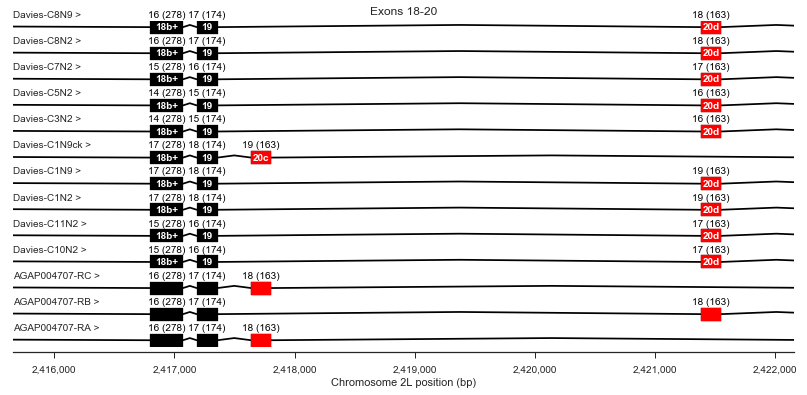

In [13]:
plot_transcripts(geneset_vgsc_combined, chrom, start+57500, start+64000,
                 label_transcripts='left', label_exons=True, label_exon_size=True, 
                 label_cdss='center', highlight_exons=highlight_exons, title='Exons 18-20')

For exon 20, Davies cDNAs and AgamP4.4 transcripts have evidence for mutually exclusive splice variants, also known as exons *c/d*.

### Exons 21-26 

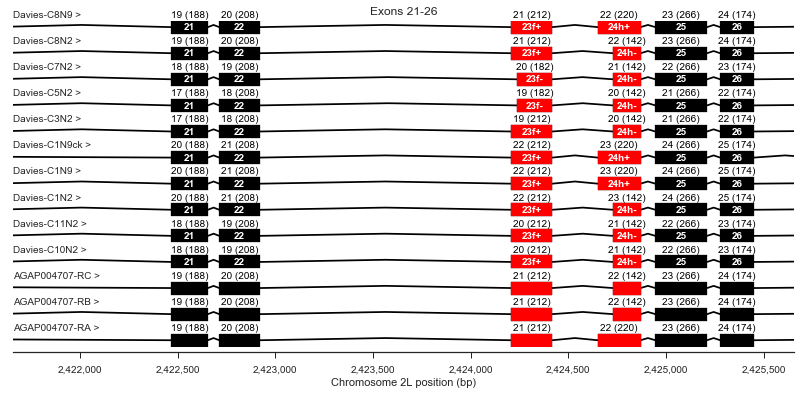

In [14]:
plot_transcripts(geneset_vgsc_combined, chrom, start+63500, start+67500,
                 label_transcripts='left', label_exons=True, label_exon_size=True, 
                 label_cdss='center', highlight_exons=highlight_exons, title='Exons 21-26')

Exon 23 has an optional region (also known as region *f*) which is missing in Davies cDNAs C5 and C7. All AgamP4.4 transcripts include this region.

Exon 24 has an optional region (also known as region *h*) which is missing in some Davies cDNAs and in two of the three AgamP4.4 transcripts.

### Exon 27

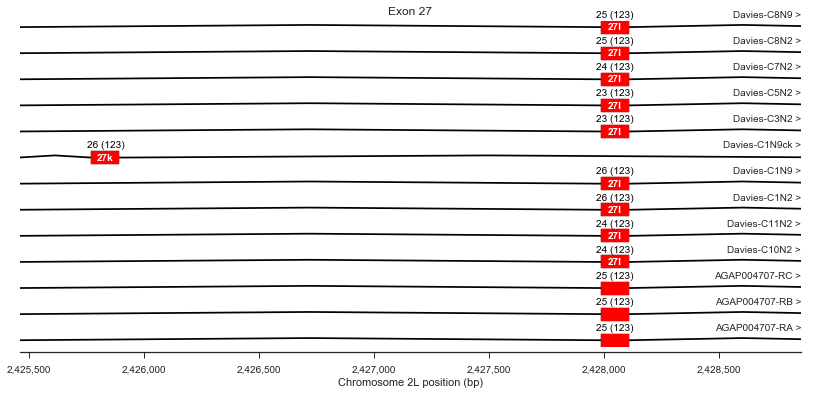

In [20]:
plot_transcripts(geneset_vgsc_combined, chrom, start+67300, start+70700,
                 label_transcripts='right', label_exons=True, label_exon_size=True, 
                 label_cdss='center', highlight_exons=highlight_exons, title='Exon 27')

Davies et al. report finding a potential alternative exon 27 (also known as mutually exclusive exon *k/l*) within the genomic DNA sequence, although they do not find any evidence for it in their cDNAs.

### Exons 28-33

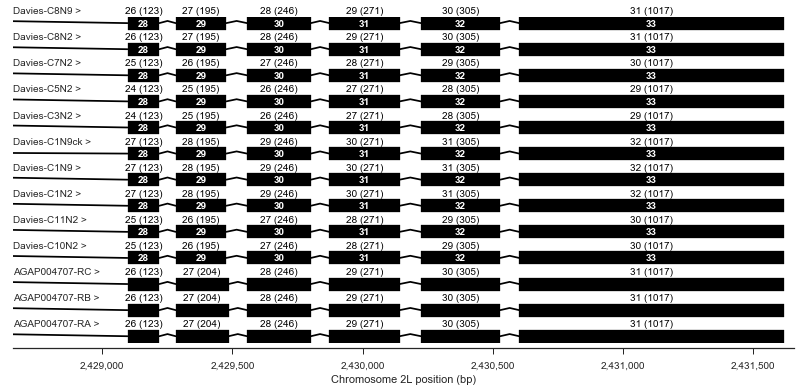

In [24]:
plot_transcripts(geneset_vgsc_combined, chrom, start+70500, start+73500,
                 label_transcripts='left', label_exons=True, label_exon_size=True, 
                 label_cdss='center', highlight_exons=highlight_exons)

No splice variation.

## Methods

TODO move this to next section: There is a bit of inconsistency in Davies et al. between the text and Figure 2C regarding whether exon 10 is also missing in cDNA C3. 